ott-jax commit hash: 72885ac75491d98e55b4f039c583134d3c2ba7b7

In [1]:
from typing import Iterator, Literal, Optional, Union
import functools
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import optax
import jax
from ott.geometry import costs
from ott.neural.flows.genot import GENOT
from ott.neural.flows.otfm import OTFlowMatching
from ott.neural.flows.models import VelocityField
from ott.neural.flows.samplers import sample_uniformly
from ott.neural.models.models import RescalingMLP
from ott.solvers.linear import sinkhorn
from ott.solvers.quadratic import gromov_wasserstein
from ott.neural.data.dataloaders import ConditionalDataLoader, OTDataLoader
from ott.neural.flows.flows import (
    BaseFlow,
    BrownianNoiseFlow,
    ConstantNoiseFlow,
)

In [2]:
@jax.tree_util.register_pytree_node_class
class CoulombCost(costs.CostFn):
    def pairwise(self, x: jnp.ndarray, y: jnp.ndarray) -> float:
        return 1.0/(jnp.linalg.norm((x-y), ord=2, axis=-1))**2
        

In [3]:
source_1 = jax.random.multivariate_normal(jax.random.PRNGKey(0), np.array([-2, -2]), 0.05*np.eye(2), (5000,))
source_2 = jax.random.multivariate_normal(jax.random.PRNGKey(0), np.array([-2, 2]), 0.05*np.eye(2), (5000,))

target_1 = jax.random.multivariate_normal(jax.random.PRNGKey(0), np.array([2, -2]), 0.05*np.eye(2), (5000,))
target_2 = jax.random.multivariate_normal(jax.random.PRNGKey(0), np.array([2, 2]), 0.05*np.eye(2), (5000,))

In [4]:
source = jax.random.permutation(jax.random.PRNGKey(0), jnp.concatenate((source_1, source_2), axis=0))
target = jax.random.permutation(jax.random.PRNGKey(0), jnp.concatenate((target_1, target_2), axis=0))

In [5]:
dl = OTDataLoader(1024, source_lin=source, target_lin=target)

In [6]:
source_test = source[:50]

In [7]:
epsilon=1e-3
iterations=3_000
source_dim = 2
target_dim = 2
condition_dim = 0
latent_embed_dim = 256
n_frequencies = 1024

# GENOT

In [8]:
neural_vf = VelocityField(
    output_dim=target_dim,
    condition_dim=source_dim + condition_dim,
    latent_embed_dim=latent_embed_dim,
    n_frequencies=n_frequencies,
)
ot_solver = sinkhorn.Sinkhorn()
time_sampler = sample_uniformly
optimizer = optax.adam(learning_rate=1e-4)
genot = GENOT(
    neural_vf,
    input_dim=source_dim,
    output_dim=target_dim,
    cond_dim=condition_dim,
    iterations=iterations,
    valid_freq=iterations,
    ot_solver=ot_solver,
    epsilon=epsilon,
    cost_fn=CoulombCost(),
    scale_cost=1.0,
    optimizer=optimizer,
    time_sampler=time_sampler,
    k_samples_per_x=1,
    solver_latent_to_data=None,
)
genot(dl, dl)


In [9]:
result_genot = genot.transport(
    source_test, condition=None, forward=True
)

In [10]:
np.save("result_genot", result_genot)

(-3.0, 3.0)

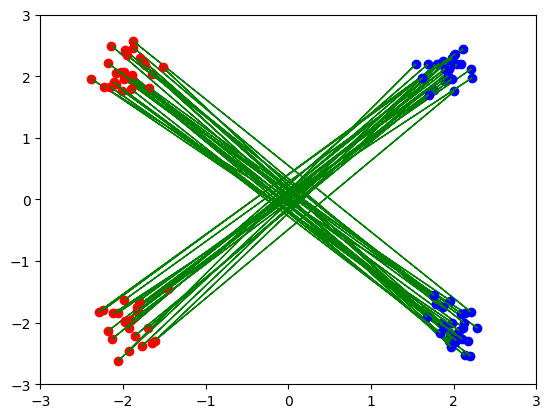

In [11]:
for source_point, target_point in zip(source_test, result_genot):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)

plt.xlim((-3, 3))
plt.ylim((-3, 3))

# OTFM (deterministic)

In [12]:
neural_vf_fm = VelocityField(
    output_dim=target_dim,
    condition_dim=condition_dim,
    latent_embed_dim=latent_embed_dim,
)

fm = OTFlowMatching(
        neural_vf_fm,
        input_dim=source_dim,
        cond_dim=condition_dim,
        iterations=iterations,
        valid_freq=iterations,
        ot_solver=ot_solver,
        flow=ConstantNoiseFlow(0),
        time_sampler=time_sampler,
        optimizer=optimizer,
        epsilon=epsilon,
        cost_fn=CoulombCost(),
        scale_cost=1.0,
    )
fm(dl, dl)

In [13]:
result_fm = fm.transport(
    source_test, condition=None, forward=True
)

In [14]:
np.save("result_ot_cfm_deterministic", result_fm)

(-3.0, 3.0)

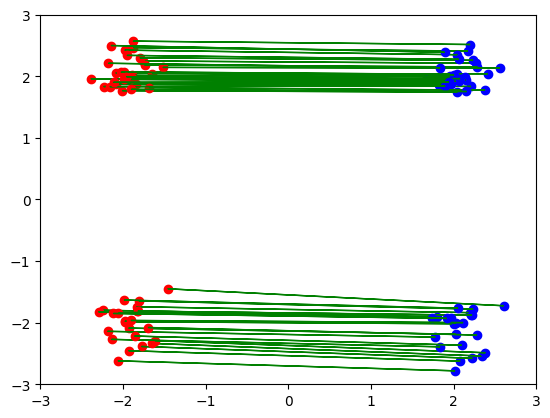

In [15]:
for source_point, target_point in zip(source_test, result_fm):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)

plt.xlim((-3, 3))
plt.ylim((-3, 3))

# OTFM Brownian bridge

In [16]:
neural_vf_fm = VelocityField(
    output_dim=target_dim,
    condition_dim=condition_dim,
    latent_embed_dim=latent_embed_dim,
)

sigma = np.sqrt(epsilon/2.0)

fm = OTFlowMatching(
        neural_vf_fm,
        input_dim=source_dim,
        cond_dim=condition_dim,
        iterations=iterations,
        valid_freq=iterations,
        ot_solver=ot_solver,
        flow=BrownianNoiseFlow(sigma),
        time_sampler=time_sampler,
        optimizer=optimizer,
        epsilon=epsilon,
        cost_fn=CoulombCost(),
        scale_cost=1.0,
    )
fm(dl, dl)

In [17]:
result_fm = fm.transport(
    source_test, condition=None, forward=True
)

In [18]:
np.save("result_ot_cfm_entropic", result_fm)

(-3.0, 3.0)

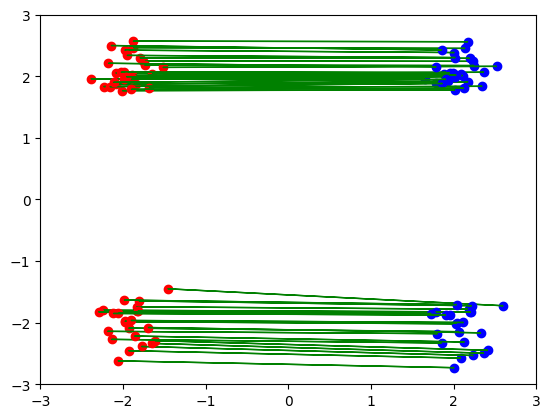

In [19]:
for source_point, target_point in zip(source_test, result_fm):
    plt.scatter(*source_point, color='red')  # Plot source point
    plt.scatter(*target_point, color='blue')   # Plot target point
    plt.arrow(source_point[0], source_point[1],  # Draw arrow
              target_point[0] - source_point[0], target_point[1] - source_point[1],
              color='green', width=0.001, head_width=0.01, length_includes_head=True)
plt.xlim((-3, 3))
plt.ylim((-3, 3))

# Data

(-3.0, 3.0)

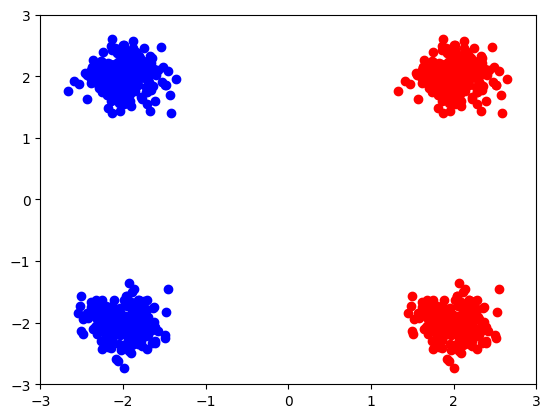

In [20]:
plt.scatter(
    source[:500, 0], 
    source[:500, 1],
    color="blue",
)
plt.scatter(
    target[:500, 0], 
    target[:500, 1],
    color="red",
)

plt.xlim((-3, 3))
plt.ylim((-3, 3))

In [21]:
np.save("source_test", source_test)
np.save("source", source)
np.save("target", target)